# QGLOSA

## Setup

In [9]:
#!pip install qiskit qiskit-aer numpy matplotlib scikit-learn

In [42]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Statevector, Pauli

## Dataset

In [43]:
df = pd.read_csv("cleaned_MPC.csv")
df = df[(df["time"] >= 5) & (df["time"] <= 20)].reset_index(drop=True)
t_data = df["time"].values
v_true = df["velocity"].values
a_true = df["acceleration"].values
dt = np.mean(np.diff(t_data))

In [95]:
# Bounds
v_min, v_max = 0.0, 15.0
a_max = 3.0
u_max = 5.0

## Example 3 of the paper

In [96]:
t = Parameter("t")
theta = Parameter("θ")
phi = Parameter("φ")
qc = QuantumCircuit(1)
qc.ry(theta * t, 0)
qc.ry(phi, 0)
qc.draw()

┌─────────┐┌───────┐
q: ┤ Ry(t*θ) ├┤ Ry(φ) ├
   └─────────┘└───────┘

In [97]:
# Normalize jerk signal to get φ(u) ∈ [0, 2π)
a_true = df["acceleration"].values
jerk = np.gradient(np.gradient(a_true, dt), dt)
jerk_norm = (jerk - jerk.min()) / (jerk.max() - jerk.min())
phi_u = 2 * np.pi * jerk_norm

In [98]:
def evaluate_velocity(t_val, phi_val, theta_val):
    bound_qc = qc.assign_parameters({
        t: t_val,
        phi: phi_val,
        theta: theta_val
    })
    sv = Statevector.from_instruction(bound_qc)
    z_expect = sv.expectation_value(Pauli("Z"))
    return (v_max - v_min) / 2 * z_expect.real + (v_max + v_min) / 2


def numerical_derivative(y, dt):
    return np.gradient(y, dt)


def compute_loss(theta_val):
    v_pred = np.array([
        evaluate_velocity(ti, phi_u[i], theta_val[0])
        for i, ti in enumerate(t_data)])
    x_pred = np.cumsum(v_pred) * dt
    a_pred = numerical_derivative(v_pred, dt)
    u_pred = numerical_derivative(a_pred, dt)
    R_x = np.gradient(x_pred, dt) - v_pred
    R_v = np.gradient(v_pred, dt) - a_pred
    R_a = np.gradient(a_pred, dt) - u_pred
    penalty_a = np.maximum(0, np.abs(a_pred) - a_max)
    penalty_u = np.maximum(0, np.abs(u_pred) - u_max)
    residual_loss = np.mean(R_x**2 + R_v**2 + R_a**2)
    penalty_loss = np.mean(penalty_a**2 + penalty_u**2)
    return residual_loss + 10 * penalty_loss

In [99]:
# Dummy x_true from integrated velocity (for residual R_x)
x_true = np.cumsum(v_true) * dt
# Optimization
result = minimize(
    fun=compute_loss,
    x0=np.array([0.1]),
    method='L-BFGS-B',
    bounds=[(-np.pi, np.pi)],
    options={"disp": True}
)
# Check
opt_theta = result.x[0]
print("Optimized θ =", opt_theta)

/tmp/ipython-input-2438233905.py:4: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


Optimized θ = 1.8319426161203847


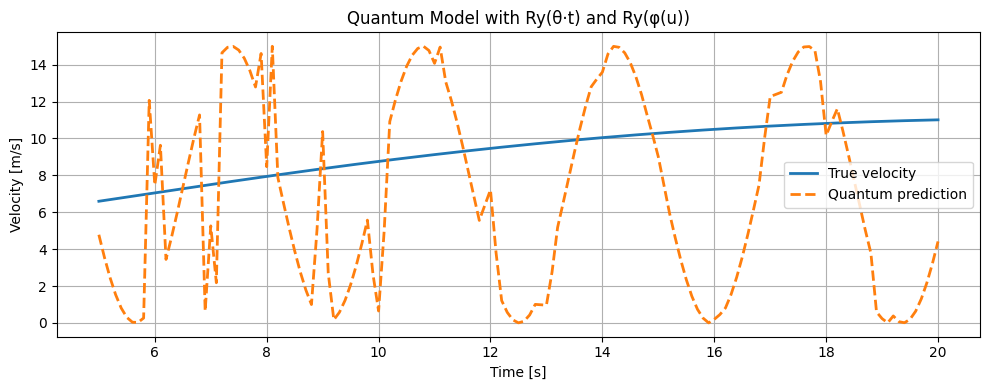

In [100]:
v_pred = np.array([
    evaluate_velocity(ti, phi_u[i], opt_theta)
    for i, ti in enumerate(t_data)])
plt.figure(figsize=(10, 4))
plt.plot(t_data, v_true, label="True velocity", lw=2)
plt.plot(t_data, v_pred, '--', label="Quantum prediction", lw=2)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.title("Quantum Model with Ry(θ·t) and Ry(φ(u))")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Example 4 of the paper

In [143]:
t = Parameter("t")
theta = Parameter("θ")
phi = Parameter("φ")
# stoplight binary inputs
s = ParameterVector("s", 1)
# trainable angles for CRY gates
gamma = ParameterVector("γ", 1)
# Circuit
qc = QuantumCircuit(2)
# Time and jerk dynamics on qubit 0
qc.ry(theta * t, 0)
qc.ry(phi, 0)
# Encode stoplight states
for i in range(1):
    qc.ry(np.pi * s[i], i + 1)
# Entangle each stoplight with velocity qubit
for i in range(1):
    qc.cry(gamma[i], i + 1, 0)
qc.draw()

┌─────────┐  ┌───────┐┌──────────┐
q_0: ─┤ Ry(t*θ) ├──┤ Ry(φ) ├┤ Ry(γ[0]) ├
     ┌┴─────────┴─┐└───────┘└────┬─────┘
q_1: ┤ Ry(π*s[0]) ├──────────────■──────
     └────────────┘

In [144]:
light_states = df[["light_1"]].astype(int).values
phi_u = 2 * np.pi * ((jerk - jerk.min()) / (jerk.max() - jerk.min()))

In [146]:
def evaluate_velocity(t_val, phi_val, light_vals, theta_val, gamma_vals):
    param_dict = {
        t: t_val,
        phi: phi_val,
        theta: theta_val}
    param_dict.update({s[i]: light_vals[i] for i in range(1)})
    param_dict.update({gamma[i]: gamma_vals[i] for i in range(1)})
    bound_qc = qc.assign_parameters(param_dict)
    sv = Statevector.from_instruction(bound_qc)
    z_expect = sv.expectation_value(Pauli("ZI"))
    return (v_max - v_min) / 2 * z_expect.real + (v_max + v_min) / 2


In [154]:
def compute_loss(params):
    theta_val = params[0]
    gamma_vals = [params[1]]
    v_pred = np.array([
        evaluate_velocity(t_data[i], phi_u[i], light_states[i], theta_val, gamma_vals)
        for i in range(len(t_data))])
    x_pred = np.cumsum(v_pred) * dt
    a_pred = numerical_derivative(v_pred, dt)
    u_pred = numerical_derivative(a_pred, dt)
    R_x = np.gradient(x_pred, dt) - v_pred
    R_v = np.gradient(v_pred, dt) - a_pred
    R_a = np.gradient(a_pred, dt) - u_pred
    penalty_a = np.maximum(0, np.abs(a_pred) - a_max)
    penalty_u = np.maximum(0, np.abs(u_pred) - u_max)
    residual_loss = np.mean(R_x**2 + R_v**2 + R_a**2)
    penalty_loss = np.mean(penalty_a**2 + penalty_u**2)
    return residual_loss + 10 * penalty_loss

In [155]:
result = minimize(
    fun=compute_loss,
    x0=np.random.uniform(-np.pi, np.pi, 2),
    method='L-BFGS-B',
    bounds=[(-np.pi, np.pi)] * 2,
    options={"disp": True}
)

opt_params = result.x
opt_theta = opt_params[0]
opt_gamma = opt_params[1]

print("Optimized θ  =", opt_theta)
print("Optimized γs =", opt_gamma)

/tmp/ipython-input-2560703506.py:1: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


Optimized θ  = 2.142623599403837
Optimized γs = 0.2631538849040765


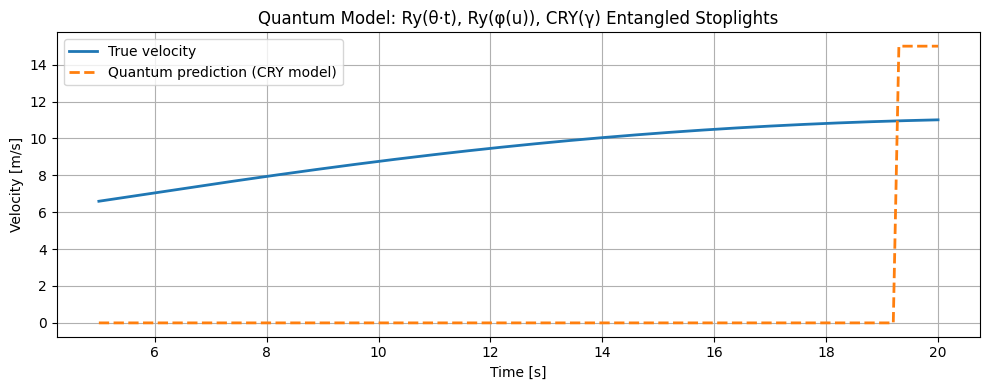

In [157]:
v_pred = np.array([
    evaluate_velocity(t_data[i], phi_u[i], light_states[i], opt_theta, [opt_gamma])
    for i in range(len(t_data))])
plt.figure(figsize=(10, 4))
plt.plot(t_data, v_true, label="True velocity", lw=2)
plt.plot(t_data, v_pred, '--', label="Quantum prediction (CRY model)", lw=2)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.title("Quantum Model: Ry(θ·t), Ry(φ(u)), CRY(γ) Entangled Stoplights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()